In [16]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_rec = load_file(
    '../../data/comfort/2018-04-23_12-30-38.csv', bicycle_calibration['convbike'])
lidar_rec = load_converted_record(
    '../../data/comfort/2018-04-23-12-17-37_0.pkl.gz')

r = Record(lidar_rec, bicycle_rec)
r.sync()

18.512

In [18]:
r.bicycle

rec.array([ (   18.512   , -0.67684991,  0.00125928, -0.22684015, -1.81434514,  9.40658534,  0.01052403, -0.00695461, -0.00039456,  0.),
           (   18.519991, -0.67684991,  0.00125928, -0.22870405, -1.83043354,  9.40952834,  0.00823904, -0.00625159, -0.00203412,  0.),
           (   18.527991, -0.67684991,  0.00125928, -0.22232755, -1.86937924,  9.42120224,  0.00823904, -0.00343917, -0.00039456,  0.),
           ...,
           ( 2036.069667, -0.20358242,  0.00125928, -0.26725735, -1.20023914,  9.52067564,  0.00419634, -0.00396661,  0.00920912,  0.),
           ( 2036.077668, -0.20579395,  0.00125928, -0.23586535, -1.34395564,  9.52822934,  0.0057783 , -0.00466963,  0.00417297,  0.),
           ( 2036.08567 , -0.20579395,  0.00125928, -0.20251135, -1.33159504,  9.49114754,  0.00191135, -0.00414236, -0.000863  ,  0.)], 
          dtype=[('time', '<f8'), ('steer angle', '<f8'), ('speed', '<f8'), ('accelerometer x', '<f8'), ('accelerometer y', '<f8'), ('accelerometer z', '<f8'), ('gyr

<IPython.core.display.Javascript object>


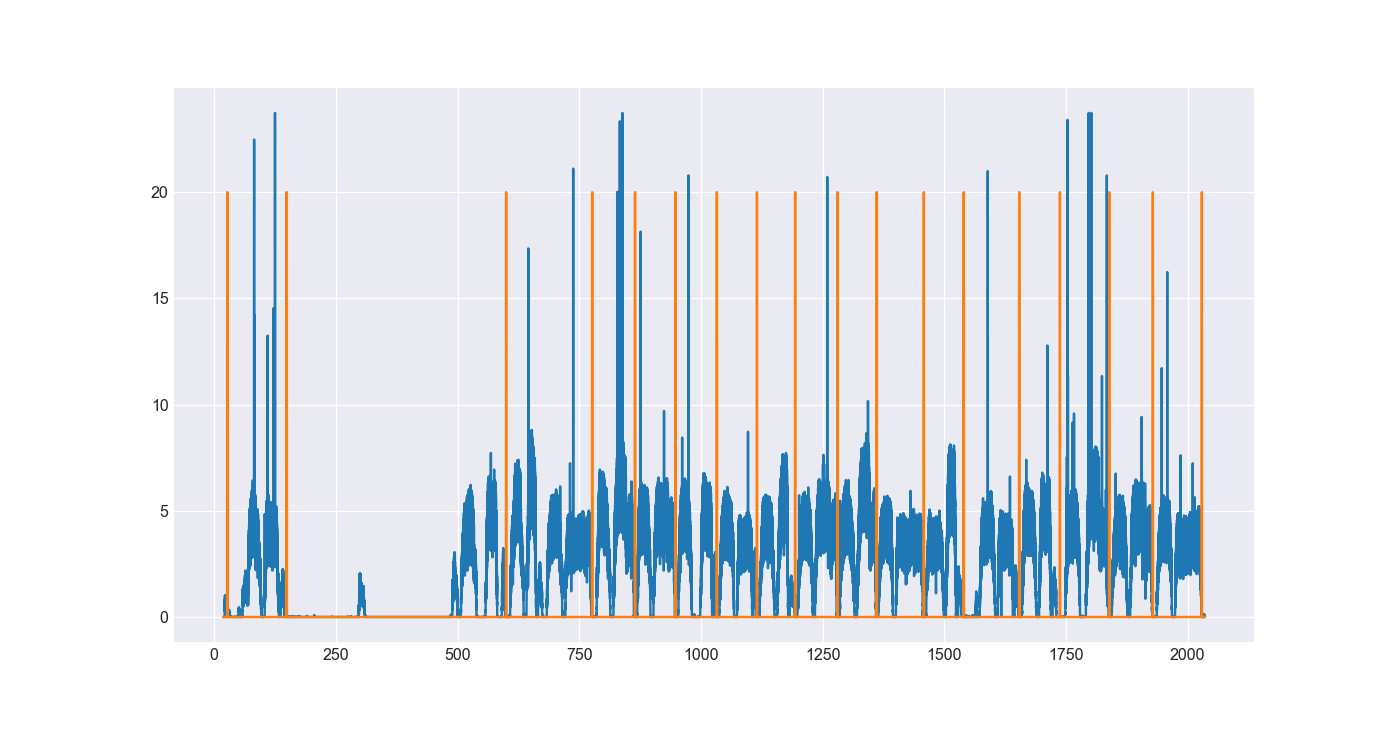

In [19]:
DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook

plt.close('all')
fig, ax = plt.subplots()
ax.plot(r.bicycle.time, r.bicycle.speed)
ax.plot(r.bicycle.time, 20*r.bicycle.sync)
plt.show()

<IPython.core.display.Javascript object>


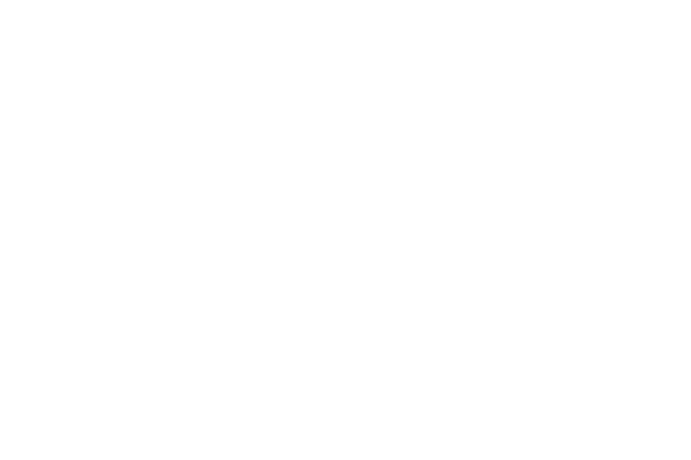

In [20]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    IPython.display.display(IPython.display.HTML(animation.to_html5_video()))
    
display_animation(r.lidar.frame(lambda t: (t > 1172) & (t < 1190)).animate(
    xlim=(-40, 110),
    ylim=(0, 4),
    rlim=(0, 110)))

<IPython.core.display.Javascript object>


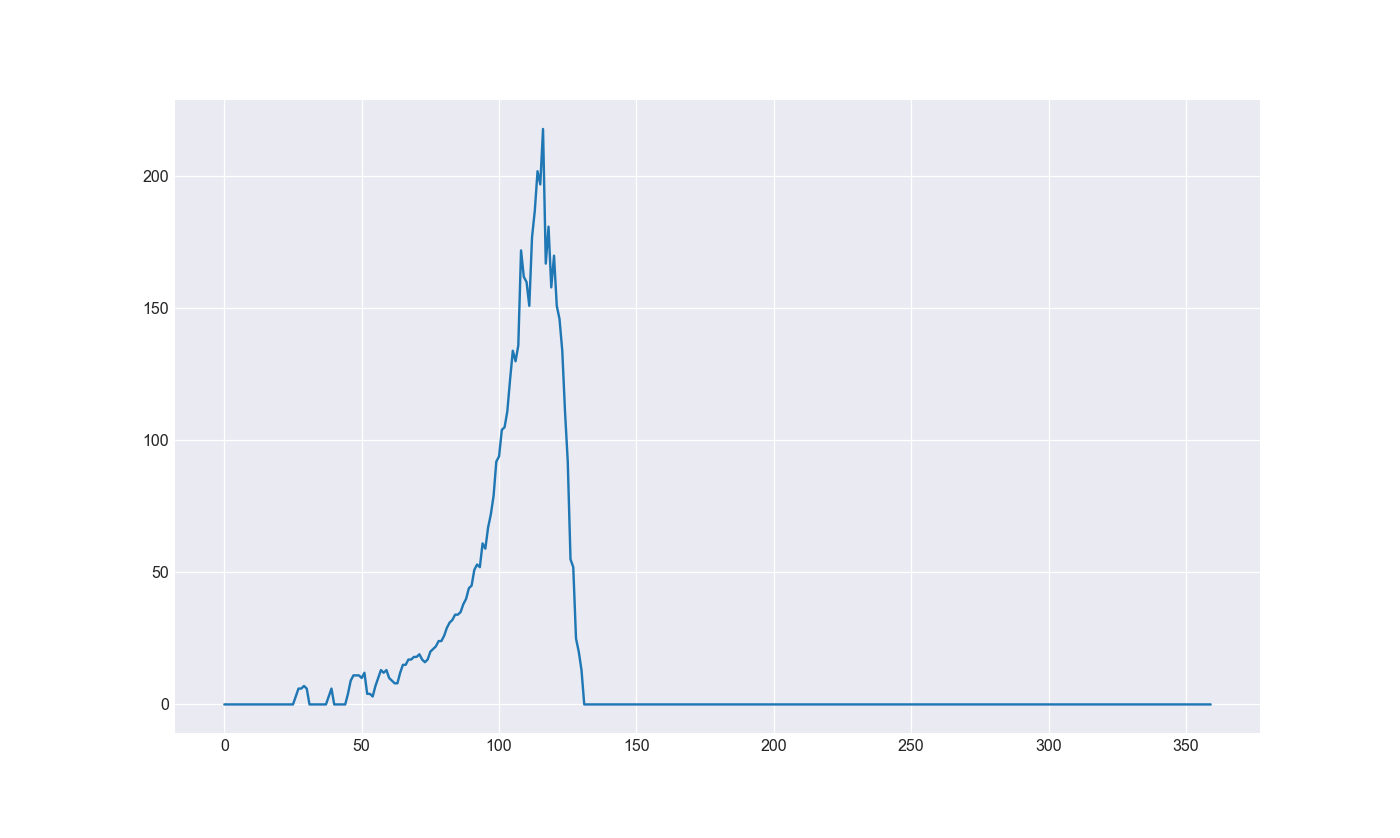

In [21]:
x, y = r.lidar.frame(lambda t: (t > 1172) & (t < 1190)).cartesian(xlim=(0, 110), ylim=(0, 4))

plt.close('all')
fig, ax = plt.subplots()
ax.plot(x.count(axis=1))
plt.show()

In [22]:
# get subrecord from bicycle data (high frequency)
hf_range = np.where(r.bicycle.sync > 0)[0][[0, -1]]
print(hf_range)

# get equivalent start point in lidar data (low frequency)
# in_view = r.lidar.cartesian(xlim=(0, 100), ylim=(0, 4))[0].count(axis=1) > 1
lf_start = np.where(r.lidar.sync > 0)[0][0]
print(lf_start)

hf_time = r.bicycle.time[hf_range[0]:hf_range[-1]]
hf_time -= hf_time[0]

lf_time = r.lidar.time[lf_start:]
lf_time -= lf_time[0]

lf_lidar_inrange = r.lidar.cartesian(xlim=(0, 100), ylim=(0, 4))[0].count(axis=1) > 1
hf_lidar_inrange = np.interp(hf_time, lf_time, lf_lidar_inrange[lf_start:])

event_mask = np.logical_and(hf_lidar_inrange, (r.bicycle.speed > 1)[hf_range[0]:hf_range[-1]])

[   981 250535]
526


<IPython.core.display.Javascript object>


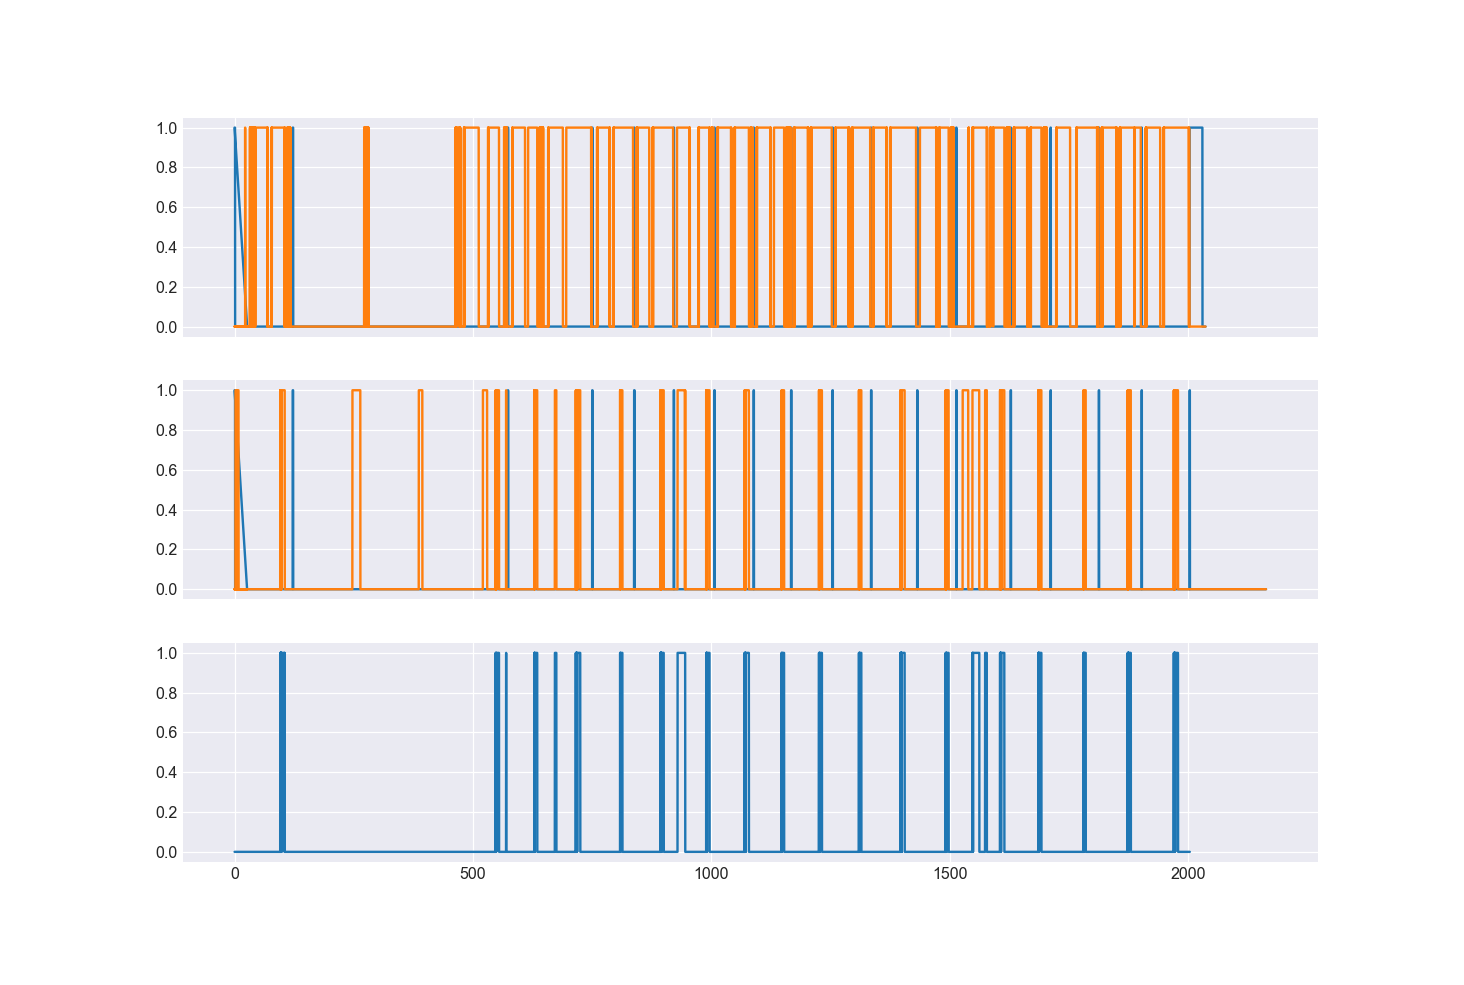

In [24]:
#filter on x, y box defined by points (0, 0) and (110, 4)
plt.close('all')
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(r.bicycle.time, r.bicycle.sync)
ax[0].plot(r.bicycle.time, r.bicycle.speed > 1)

ax[1].plot(r.lidar.time, r.lidar.sync)
ax[1].plot(r.lidar.time, r.lidar.cartesian(xlim=(0, 100), ylim=(0, 4))[0].count(axis=1) > 1)

ax[2].plot(r.bicycle.time[hf_range[0]:hf_range[-1]], event_mask)
plt.show()